<a href="https://colab.research.google.com/github/Sourav56/Computer-Vision/blob/master/ssd_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
import os
import zipfile
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
directory=r'/content/drive/My Drive/Colab Notebooks/facemaskdetection'
category =  os.listdir(directory)
print(category)

['without_mask', 'with_mask']


In [ ]:
yes_im = r'/content/drive/My Drive/Colab Notebooks/facemaskdetection/with_mask'
no_im = r'/content/drive/My Drive/Colab Notebooks/facemaskdetection/without_mask'

In [ ]:
print("The number of images with facemask labelled 'yes':",len(os.listdir(yes_im)))
print("The number of images with facemask labelled 'no':",len(os.listdir(no_im)))

The number of images with facemask labelled 'yes': 1915
The number of images with facemask labelled 'no': 1918


In [ ]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1638 (delta 9), reused 0 (delta 0), pack-reused 1604
Receiving objects: 100% (1638/1638), 75.94 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


In [ ]:
def data_summary(code_path):
    
    yes_path = code_path+'with_mask'
    no_path = code_path+'without_mask'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path =  r'/content/drive/My Drive/Colab Notebooks/facemaskdetection/' 
data_summary(augmented_data_path)

Number of examples: 3833
Percentage of positive examples: 49.96086616227498%, number of pos examples: 1915
Percentage of negative examples: 50.03913383772502%, number of neg examples: 1918


In [ ]:
def split_data(original, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(original):
        data = original + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = original + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = original + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)
        
YES_Data = "observations/experiements/data/with_mask/"
TRAINING_YES_ = "observations/experiements/dest_folder/train/with_mask/"
TESTING_YES_ = "observations/experiements/dest_folder/test/with_mask/"

NO_Data =  "observations/experiements/data/without_mask/"
TRAINING_NO_ = "observations/experiements/dest_folder/train/without_mask/"
TESTING_NO_ = 'observations/experiements/dest_folder/test/without_mask/'
split_size = 0.8
split_data( YES_Data, TRAINING_YES_, TESTING_YES_, split_size)
split_data( NO_Data,TRAINING_NO_, TESTING_NO_, split_size)

In [ ]:
print("The number of images with facemask in the training set labelled 'yes':", len(os.listdir("observations/experiements/dest_folder/train/with_mask/")))
print("The number of images with facemask in the test set labelled 'yes':", len(os.listdir("observations/experiements/dest_folder/test/with_mask/")))
print("The number of images without facemask in the training set labelled 'no':", len(os.listdir("observations/experiements/dest_folder/train/without_mask/")))
print("The number of images without facemask in the test set labelled 'no':", len(os.listdir("observations/experiements/dest_folder/test/without_mask/")))

The number of images with facemask in the training set labelled 'yes': 735
The number of images with facemask in the test set labelled 'yes': 215
The number of images without facemask in the training set labelled 'no': 734
The number of images without facemask in the test set labelled 'no': 215


In [ ]:
image_size = 224
IMG_SHAPE = (image_size, image_size, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False
tf.keras.callbacks.EarlyStopping(
    monitor='acc', min_delta=95, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

model = tf.keras.models.Sequential([base_model,
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=IMG_SHAPE, padding = 'same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
TRAINING_DIR = "/content/drive/My Drive/Colab Notebooks/facemaskdetection/"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "observations/experiements/dest_folder/test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


Found 3833 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 100)         1152100   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 100)         90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [ ]:
history = model.fit(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/10
 59/384 [===>..........................] - ETA: 48:13 - loss: 0.6636 - acc: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


384/384 [==============================] - ETA: 0s - loss: 0.2492 - acc: 0.9296WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
384/384 [==============================] - 3191s 8s/step - loss: 0.2492 - acc: 0.9296 - val_loss: 0.0595 - val_acc: 0.9721
Epoch 2/10
384/384 [==============================] - 71s 186ms/step - loss: 0.1093 - acc: 0.9663 - val_loss: 0.0181 - val_acc: 0.9953
Epoch 3/10
384/384 [==============================] - 47s 124ms/step - loss: 0.0800 - acc: 0.9747 - val_loss: 0.0198 - val_acc: 0.988

In [ ]:
model.save("my_h5_model.h5")

In [ ]:
face_mask = tf.keras.models.load_model('my_h5_model.h5')

In [ ]:
face_mask.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 100)         1152100   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 100)         90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [ ]:
face_detector=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

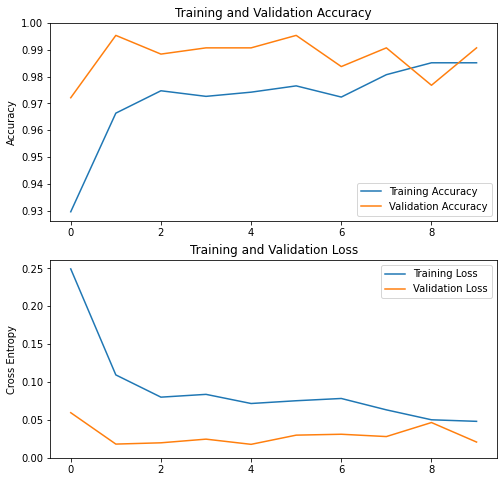

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
face_mask.layers[0].input_shape

(None, 224, 224, 3)

In [ ]:
classes = validation_generator.class_indices    
print(classes)

{'with_mask': 0, 'without_mask': 1}
